# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport
%env CUDA_VISIBLE_DEVICES=0
%env BLISS_HOME=/home/yppatel/bliss

Modules to reload:
all-except-skipped

Modules to skip:

env: CUDA_VISIBLE_DEVICES=0
env: BLISS_HOME=/home/yppatel/bliss


In [9]:
%matplotlib inline 

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch

from bliss.inference import SDSSFrame
from bliss.datasets import sdss
from bliss.inference import reconstruct_scene_at_coordinates
from case_studies.substructure.plots.main import load_models


from astropy.table import Table

import plotly.express as px
import plotly.graph_objects as go

In [4]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

0


# Encoder blend images

In [5]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="config"):
    cfg = compose("config", overrides=[])
    
    
enc, dec = load_models(cfg, device)
bp = enc.border_padding
torch.cuda.empty_cache()

In [6]:
dataset = instantiate(
    cfg.datasets.simulated,
    generate_device="cuda:0",
)

In [16]:
sample_batch_size = 16
tile_catalog = dataset.sample_prior(sample_batch_size, cfg.datasets.simulated.n_tiles_h, cfg.datasets.simulated.n_tiles_w)
tile_catalog.set_all_fluxes_and_mags(dataset.image_decoder)

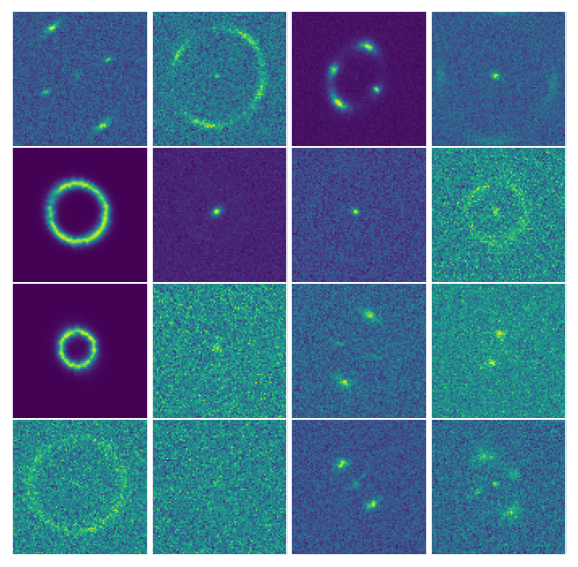

In [17]:
images, backgrounds = dataset.simulate_image_from_catalog(tile_catalog)
plt.rcParams["axes.grid"] = False

fig, axs = plt.subplots(sample_batch_size // 4, 4, figsize=(6, 6), dpi=120)
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(sample_batch_size):
    axs[i // 4, i % 4].imshow(images[i,0,:,:].cpu())
    axs[i // 4, i % 4].set_xticklabels([])
    axs[i // 4, i % 4].set_yticklabels([])
    axs[i // 4, i % 4].tick_params(left = False, bottom = False)

In [11]:
full_true = tile_catalog.cpu().to_full_params()

In [13]:
full_true.plocs[0]

tensor([[0., 0.]])

In [9]:
galaxy = instantiate(cfg.models.galaxy_encoder).to(device).eval()
galaxy.load_state_dict(torch.load(cfg.plots.galaxy_checkpoint, map_location=galaxy.device))

lens = instantiate(cfg.models.lens_encoder).to(device).eval()
lens.load_state_dict(torch.load(cfg.plots.lens_checkpoint, map_location=lens.device))

<All keys matched successfully>

In [61]:
from bliss.catalog import get_images_in_tiles

full_true = tile_catalog.cpu().to_full_params()

for i, (image, background) in enumerate(zip(images, backgrounds)):
    img_bg = torch.cat((image, background), dim=0).unsqueeze((0)).to(dec.device)
    gal_enc = galaxy.sample(img_bg, tile_catalog.locs[i], deterministic=True)
    lens_enc = lens.sample(img_bg, tile_catalog.locs[i], deterministic=True)
    
    print(gal_enc)
    print(full_true["galaxy_params"][i])
    print("----------------")

tensor([[[[61.1710,  0.4832,  3.2744,  0.5357,  1.6356,  0.4947,  1.0158]]]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor([[1.3161e+03, 3.0348e-01, 1.6234e+00, 9.8100e-01, 1.1391e+00, 3.6389e-01,
         1.3720e+00]])
----------------
tensor([[[[2.1078e+05, 5.1348e-01, 4.4167e+00, 3.0619e-01, 4.6625e+00,
           5.3374e-01, 1.3043e+00]]]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
tensor([[5.6753e+03, 8.8484e-01, 6.1518e+00, 6.5724e-01, 9.1255e-01, 4.8500e-01,
         1.4261e+00]])
----------------
tensor([[[[60.8997,  0.4834,  3.2722,  0.5360,  1.6365,  0.4942,  1.0156]]]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor([[6.7253e+02, 8.7892e-01, 2.3972e+00, 7.5392e-01, 1.1038e+00, 6.2036e-01,
         2.0741e+00]])
----------------
tensor([[[[90.0453,  0.4896,  3.7198,  0.4668,  1.3011,  0.4431,  0.9129]]]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor([[6.4070e+02, 2.1486e-01, 5.5738e+00, 7.8469e-02, 1.3949e+00, 8.0318e-01,
        